# Importing data

In [ ]:
# install kaggle to access dataset
!pip install kaggle

In [ ]:
# enable kaggle API
# note: you NEED to have your kaggle token saved in drive for this to work (https://github.com/Kaggle/kaggle-api)
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
 from kaggle.api.kaggle_api_extended import KaggleApi
 api = KaggleApi()
 api.authenticate()

In [ ]:
# download HASYV2 dataset
api.dataset_download_files('guru001/hasyv2')

In [ ]:
# unzip data
!unzip hasyv2.zip

# Resample Data

In [ ]:
imgs_path = 'hasyv2/'
labels_path = 'hasyv2/hasy-data-labels.csv'

In [ ]:
from sklearn.utils import resample
import pandas as pd
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
import numpy as np
from torch import nn

In [ ]:
# balance original classes in dataset
# overwrite the original csv
old_data = pd.read_csv(labels_path, sep=',', index_col=0)

In [ ]:
cnts = old_data['latex'].value_counts()

values = []
indices = []
# remove axes
np.average(cnts.values)
# resample every one so that there are at least 700 samples of each
for idx in cnts.index:
  if cnts[idx] < 700:
    vals = np.concatenate((resample(old_data[old_data['latex']==idx], n_samples = 700-cnts[idx], random_state=123).values, old_data[old_data['latex']==idx].values))
    filenames = resample(old_data[old_data['latex']==idx], n_samples = 700-cnts[idx], random_state=123).append(old_data[old_data['latex']==idx]).index

  else:
    vals = resample(old_data[old_data['latex']==idx], n_samples = 700, random_state=123, replace=False).values
    filenames = resample(old_data[old_data['latex']==idx], n_samples = 700, random_state=123, replace=False).index

  for val in vals:
    values.append(val)
  for name in filenames:
    indices.append(name)

resampled_data = pd.DataFrame(values, index=indices, columns=['symbol_id', 'latex', 'user_id'])
# overwrite the old .csv file

In [ ]:
remove = [
'\\bowtie',
'\\|',
'\\bot',
'\\amalg',
'|',
'\\prod',
'\\dotsc',
'\\ohm',
'\\sum',
'\\S',
'\\varpropto',
'\\with',
'\\checked',
'\\setminus',
'\\shortrightarrow',
'\\longrightarrow',
'\\Longrightarrow',
'\\Longleftrightarrow',
'\\male',
'\\female',
'\\vartriangle']

In [ ]:
resampled_data

,symbol_id,latex,user_id
hasy-data/v2-56668.png,183,\int,16925
hasy-data/v2-56071.png,183,\int,16925
hasy-data/v2-58513.png,183,\int,16925
hasy-data/v2-55758.png,183,\int,16925
hasy-data/v2-57689.png,183,\int,16925
...,...,...,...
hasy-data/v2-165930.png,1315,\mathbb{N},10
hasy-data/v2-165931.png,1315,\mathbb{N},10
hasy-data/v2-165932.png,1315,\mathbb{N},10
hasy-data/v2-165933.png,1315,\mathbb{N},10


In [ ]:
resampled_data_new = resampled_data[~resampled_data.latex.isin(remove)]

In [ ]:
resampled_data_new

,symbol_id,latex,user_id
hasy-data/v2-56668.png,183,\int,16925
hasy-data/v2-56071.png,183,\int,16925
hasy-data/v2-58513.png,183,\int,16925
hasy-data/v2-55758.png,183,\int,16925
hasy-data/v2-57689.png,183,\int,16925
...,...,...,...
hasy-data/v2-165930.png,1315,\mathbb{N},10
hasy-data/v2-165931.png,1315,\mathbb{N},10
hasy-data/v2-165932.png,1315,\mathbb{N},10
hasy-data/v2-165933.png,1315,\mathbb{N},10


In [ ]:
len(remove)

21

In [ ]:
all_data =  resampled_data_new

# all_data

# save this to a new csv
labels_path = 'hasyv2/augmented_data.csv'
all_data.to_csv(labels_path)

In [ ]:
data = pd.read_csv(labels_path, sep=',', index_col=0)

# Symbols Dataset

In [ ]:
from sklearn.utils import resample
import pandas as pd
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
import numpy as np
from torch import nn
# creating own DatasetClass (this is like an ImageFolder, except custom so that we don't have to arrange images in a directory by label)
class SymbolsDataset(Dataset):
    def __init__(self, labels_path, imgs_path, indices):
        """
        Initialize data set as a list of IDs corresponding to each item of data set
        :param img_dir: path to image files as a uncompressed tar archive
        :param txt_path: a text file containing names of all of images line by line
        """
        # Read in the dataframe
        data = pd.read_csv(labels_path, sep=',', index_col=0)
        
        # Convert the column into a list
        master_list = []
        for i in range(data.shape[0]):
          master_list.append(data.iloc[i, 1])

        # Extract just the unique values (i.e. the set)
        unique = np.unique(master_list)

        # Create a mapping between each symbol and an ID in [0,...,368]
        dict_id = {}
        i = 0
        for symbol in unique:
          dict_id[symbol] = i
          i = i + 1

        # Add an class_id column to represent the class for each
        data["class_id"] = 0

        # Iterate through the dataframe and add in the new id
        for i in range(data.shape[0]):
          data.iloc[i, 3] = dict_id[data.iloc[i, 1]]

        # Finally, declare self.df
        self.df = data.iloc[indices,:] # use data, but only at relevant indices to either train/test/validate
        self.img_names = self.df.index.values
        self.labels_path = labels_path
        self.imgs_path = imgs_path
        self.transform = transforms.Compose([transforms.ToTensor()])

    def get_image_from_folder(self, name):
        """
        gets a image by a name gathered from file list text file
        :param name: name of targeted image
        :return: a PIL image
        """
        image = Image.open(os.path.join(self.imgs_path, name))
        return image

    def __len__(self):
        """
        Return the length of data set using list of IDs
        :return: number of samples in data set
        """
        return len(self.img_names)

    def __getitem__(self, index):
        """
        Generate one item of data set. 
        """
        img = self.get_image_from_folder(self.img_names[index])
        img = img.convert('L') 
        img = self.transform(img)
        #img = np.squeeze(img)
        #lbl = self.df.iloc[index][1]
        lbl = torch.tensor(self.df.iloc[index][3])

        return (img, lbl)

# Expressions Dataset

In [ ]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
import numpy as np
np.random.seed(1)
# creating own DatasetClass (this is like an ImageFolder, except custom so that we don't have to arrange images in a directory by label)
class BoundingBoxDataset(Dataset):  
    def __init__(self, labels_path, imgs_path, indices): # can maybe also feed this a list of indices of the relevant train/test
        """
        Initialize data set as a list of IDs corresponding to each item of data set
        :param img_dir: path to image files as a uncompressed tar archive
        :param txt_path: a text file containing names of all of images line by line
        """
        # Read in the dataframe
        data = pd.read_csv(labels_path, sep=',', index_col=0)
        
        # Convert the column into a list
        master_list = []
        for i in range(data.shape[0]):
          master_list.append(data.iloc[i, 1])

        # Extract just the unique values (i.e. the set)
        unique = np.unique(master_list)

        # Create a mapping between each symbol and an ID in [0,...,368]
        dict_id = {}
        i = 0
        for symbol in unique:
          dict_id[symbol] = i
          i = i + 1

        # Add an class_id column to represent the class for each
        data["class_id"] = 0

        # Iterate through the dataframe and add in the new id
        for i in range(data.shape[0]): # note: could change this to iterate thru a list instead
          data.iloc[i, 3] = dict_id[data.iloc[i, 1]]

        # Finally, declare self.df
        self.df = data.iloc[indices,:] # use data, but only at relevant indices to either train/test/validate
        self.img_names = self.df.index.values
        self.labels_path = labels_path
        self.imgs_path = imgs_path
        self.transform = transforms.Compose([transforms.ToTensor()])
        # initial object transform
        self.t1 = transforms.Compose([  
                                        transforms.RandomAffine(degrees=5, scale=(.9,1.1), fillcolor=(255,255,255))
                                      , transforms.Resize(32)])
        # another transform for individual images (make sure that output is still 32x32)
        
    def get_image_from_folder(self, name):
        """
        gets a image by a name gathered from file list text file
        :param name: name of targeted image
        :return: a PIL image
        """
        image = Image.open(os.path.join(self.imgs_path, name))
        return image

    def __len__(self):
        """
        Return the length of data set using list of IDs
        :return: number of samples in data set
        """
        return len(self.img_names)

    # define a function for an image paste

    def __getitem__(self, index):
        """
        Generate one item of data set. 
        """
        indices = [index] # first index
        img = self.get_image_from_folder(self.img_names[index]) # get initial image
        images = [img]

        n=np.random.randint(2,9) # n = how many additional characters are we adding?
        for i in range(n): # open each of the n additional images
          rand_idx = np.random.randint(0, self.df.shape[0])
          indices.append(rand_idx)
          images.append(self.get_image_from_folder(self.img_names[rand_idx]))

        # create a 350x350 blank image
        new_im = Image.new('RGB', (350, 350), (255, 255, 255))
        # choose initial point x,y to start pasting
        x_init = np.random.randint(0, 350-(n+1)*32)
        y_init = np.random.randint(0,350-32)

        x_s = [x_init] # keep track of x coordinates
        y_s = [y_init] # all the ys are the same
        x_offset = 0
        y_offset = 0
        for im in images: # pastes all of the images into new_im
          # transform the original image
          im = self.t1(im)
          new_im.paste(im, (x_offset,y_init+y_offset))
          x_s.append(x_offset)
          y_s.append(y_init+y_offset)
          y_offset = np.random.randint(-5,5)
          x_rand = np.random.randint(0,10)
          x_offset += im.size[0] + x_rand

        image = image.convert('L')
        image = self.transform(new_im) # transform to tensor 
        # lbl = torch.tensor(self.df.iloc[index][3]) 
        labels = []
        for idx in indices: labels.append(self.df.iloc[idx][3])
        
        lbl = list((zip(x_s, y_s, labels)))         # new label will be n+1 tuples containing x_coord, y_coord, img_label)
        return (image, lbl)
        # since we're working with 32/32 shapes: x2 = x+32, y2=y+32 gives us our bounding box

# Export

In [ ]:
# hyperparameters: update batch size, test/validation split
test_val_split = 0.2

# Creating data indices for training and validation splits:
dataset_size = len(all_data.index)
indices = list(range(dataset_size))
split = int(np.floor(test_val_split * dataset_size))

np.random.seed(3)
np.random.shuffle(indices)

test_indices, val_indices, train_indices = indices[:split], indices[split:2*split], indices[2*split:]

train_dataset = SymbolsDataset(labels_path, imgs_path, indices = train_indices)
val_dataset = SymbolsDataset(labels_path, imgs_path, indices = val_indices)
test_dataset = SymbolsDataset(labels_path, imgs_path, indices = test_indices)

# train_dataset = BoundingBoxDataset(labels_path, imgs_path, indices = train_indices)
# val_dataset = BoundingBoxDataset(labels_path, imgs_path, indices = val_indices)
# test_dataset = BoundingBoxDataset(labels_path, imgs_path, indices = test_indices)

In [ ]:
# save these to pickle files
# sliding window algo: https://towardsdatascience.com/convolutional-implementation-of-the-sliding-window-algorithm-db93a49f99a0
# YOLO specifically: https://arxiv.org/pdf/1506.02640.pdf
# divide the input into an SxS grid
import pickle
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

with open('train_dataset_L_dropped.pkl', 'wb') as output:
    pickle.dump(train_dataset, output)
# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile('train_dataset_L_dropped.pkl')
file.Upload() 

with open('test_dataset_L_dropped.pkl', 'wb') as output:
    pickle.dump(test_dataset, output)
# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile('test_dataset_L_dropped.pkl')
file.Upload() 

with open('val_dataset_L_dropped.pkl', 'wb') as output:
    pickle.dump(val_dataset, output)
# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile('val_dataset_L_dropped.pkl')
file.Upload() 

# Open Pickle Files

In [ ]:
%cd /content/

/content


In [ ]:
from google.colab import drive
import pickle
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Year 4/APS360/APS 360 Project/Greyscale Dropped Classes/"
infile = open(DATA_PATH+'train_dataset_L_dropped.pkl','rb')
train_dataset = pickle.load(infile)
infile = open(DATA_PATH+'test_dataset_L_dropped.pkl','rb')
test_dataset = pickle.load(infile)
infile = open(DATA_PATH+'val_dataset_L_dropped.pkl','rb')
val_dataset = pickle.load(infile)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size=1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
import os

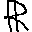

In [ ]:
iterator = 1
for img, label in train_dataset:
  iterator+=1
  i = img
  l = label
  if iterator==78: break

transforms.ToPILImage(mode='L')(i)

In [ ]:
# dict of all ids
id_to_latex = dict(set(zip(train_dataset.df['class_id'], train_dataset.df['latex'])))

In [ ]:
import pickle
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

with open('id_dict.pkl', 'wb') as output:
    pickle.dump(id_to_latex, output)
# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile('id_dict.pkl')
file.Upload() 

# Dummy Dataset for Sanity Test

In [ ]:
train_dataset

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
# hyperparameters: update batch size, test/validation split
batch_size_dumb = 1
test_val_split_dumb = 0.2

# Creating data indices for training and validation splits:
dataset_size_dumb = 1
indices_dumb = list(range(dataset_size_dumb))
split_dumb = int(np.floor(test_val_split_dumb * dataset_size_dumb))

np.random.seed(3)
np.random.shuffle(indices_dumb)

test_indices_dumb, val_indices_dumb, train_indices_dumb = indices_dumb[split_dumb:], indices_dumb[split_dumb:2*split_dumb], indices_dumb[2*split_dumb:]

# Creating PT data samplers and loaders:
train_sampler_dumb = SubsetRandomSampler(train_indices_dumb)
valid_sampler_dumb = SubsetRandomSampler(val_indices_dumb)
test_sampler_dumb = SubsetRandomSampler(test_indices_dumb)

train_loader_dumb = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_dumb, 
                                           sampler=train_sampler_dumb)
validation_loader_dumb = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_dumb,
                                                sampler=valid_sampler_dumb)
test_loader_dumb = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_dumb,
                                                sampler=test_sampler_dumb)

# Bounding Box Detection

In [ ]:
# Going to try and implement openCV, first using dummy loader
for img, lbl in train_loader_dumb:
  print(img)
  print(lbl)
  break

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])
tensor([326])


In [ ]:
toPIL=transforms.ToPILImage()
img=toPIL(np.squeeze(img))

In [ ]:
# create a PIL
new_im = Image.new('L', (350, 350), (255))
new_im.paste(img, (30,44))
new_im.paste(img, (60,100))

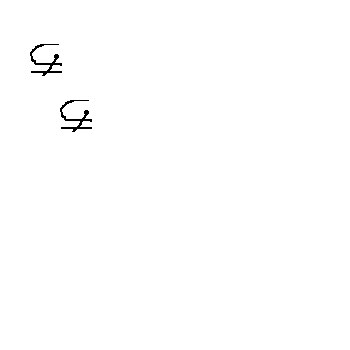

In [ ]:
new_im

In [ ]:
import cv2 as cv # import cv2

In [ ]:
import PIL

In [ ]:
inverted_image = PIL.ImageOps.invert(new_im)

In [ ]:
x,y,w,h = cv.boundingRect(np.asarray(inverted_image))

In [ ]:
x

30

In [ ]:
y

44

In [ ]:
w

62

In [ ]:
h

88

60 100 32 32
30 44 32 32


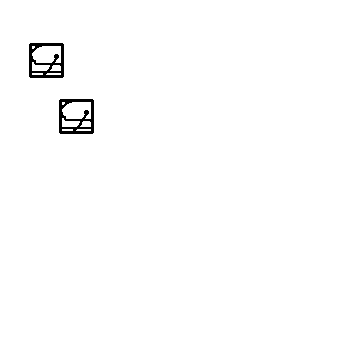

-1

In [ ]:
# find contours
new_im = np.asarray(new_im)

from google.colab.patches import cv2_imshow
thresh = cv.threshold(new_im, 0, 255, cv.THRESH_BINARY_INV)[1]

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv.boundingRect(c)
    print(x,y,w,h)
    cv.rectangle(new_im, (x, y), (x + w, y + h), (1), 2)
    ROI = new_im[y:y+h, x:x+w]
    cv.imwrite('ROI_{}.png'.format(ROI_number), ROI)
    ROI_number += 1

cv2_imshow(new_im)
cv.waitKey()

# Import Resnet Model

In [ ]:
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
from google.colab import drive
import pickle
from sklearn.utils import resample
import pandas as pd
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
import numpy as np
from torch import nn

from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        

In [ ]:
def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [ ]:
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)      

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [ ]:
class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    

In [ ]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [ ]:
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [ ]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation='relu', block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation_func(activation),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,*args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [ ]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [ ]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.name = "ResNet"
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))

In [ ]:
def resnet18(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2, 2, 2, 2], *args, **kwargs)

In [ ]:
def resnet34(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3, 4, 6, 3], *args, **kwargs)

In [ ]:
resnet_model = resnet18(1, 348)

# Model demo code

In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
from google.colab import drive
import pickle

from sklearn.metrics import confusion_matrix
import seaborn as sn
import cv2 as cv # import cv2
import PIL

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def split_symbols(img): # given an input image, split into individual symbols and paste each into a square
    # find contours
    img_np = np.asarray(img)

    from google.colab.patches import cv2_imshow
    thresh = cv.threshold(img_np, 0, 255, cv.THRESH_OTSU)[1] #cv.THRESH_OTSU

    # Find contours, obtain bounding box, extract and save ROI
    # ROI_number = 0
    cnts = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts_new = []
    for c in cnts:
      if cv.contourArea(c)/(img_np.shape[0]*img_np.shape[1]) > 3e-3 and cv.contourArea(c)/(img_np.shape[0]*img_np.shape[1]) < 0.7:
        cnts_new.append(c)

    # order bounding boxes from left to right
    boundingBoxes = [cv.boundingRect(c) for c in cnts_new]
    (cnts_new, boundingBoxes) = zip(*sorted(zip(cnts_new, boundingBoxes),
      key=lambda b:b[1][0]))

    t = transforms.Compose([transforms.Pad(2, (255)), transforms.Resize((32)), transforms.CenterCrop(32), transforms.ToTensor()])

    symbols=[]
    for x, y, w, h in boundingBoxes:
        symbol = Image.fromarray(img_np[y:y+h, x:x+w], 'L')
        dim = max(symbol.height, symbol.width)
        blank = symbol
        # Image.new('L', (dim, dim),(255))
        # blank.paste(symbol)
        symbols.append(t(blank))

    return symbols 

def get_preds(model, symbols):
    latex = ''
    for s in symbols:
      i = model(s.unsqueeze(0).cuda()).max(1, keepdim=True)[1][0][0].item()
      latex+=" "+id_dict[i]
    return latex

def display_img(symbols):
  trans = transforms.ToPILImage('L')
  return [trans(s) for s in symbols]

def display_symbols(symbols):
  pls=display_img(symbols)
  plt.figure(figsize=(len(pls),10))
  n=0
  for p in pls:
      plt.subplot(1,len(pls), n+1)
      # print(img.shape)
      # img = np.squeeze(p)
      #print(img.shape)
      #img = img.permute(1, 2, 0)
      #print(img.shape)
      plt.imshow(p)
      n+=1

In [ ]:
# import category mapping
from google.colab import drive
import pickle
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Year 4/APS360/APS 360 Project/"
infile = open(DATA_PATH+'id_dict.pkl','rb')
id_dict = pickle.load(infile)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class CNN_BN_Mod(nn.Module):
    def __init__(self):
        super(CNN_BN_Mod, self).__init__()
        self.name = "BN_Mod"
        self.conv1 = nn.Conv2d(1, 16, 3)   # Note: Only one input channel (gray scale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 120, 3)
        self.conv5 = nn.Conv2d(120, 200, 3)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(120)
        self.bn5 = nn.BatchNorm2d(200)
        self.bn_FC = nn.BatchNorm1d(75)

        self.fc1 = nn.Linear(200 * 3 * 3, 75)
        self.fc2 = nn.Linear(75, 369)

    def forward(self, img):
        x = F.relu(self.bn1(self.conv1(img)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))

        x = x.view(-1, 200 * 3 * 3)
        x = F.relu(self.bn_FC(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
from IPython.display import Math
from IPython.display import display, HTML
from google.colab.output._publish import javascript
# from google.colab import files
# upload=files.upload()

In [ ]:
%cd ..
%cd ..
%cd ..
%cd ..
%cd ..
%cd ..

/content/drive/My Drive/Year 4/APS360/APS 360 Project
/content/drive/My Drive/Year 4/APS360
/content/drive/My Drive/Year 4
/content/drive/My Drive
/content/drive
/content


**Load the model** 

In [ ]:
# load the model
path_test = 'drive/My Drive/Year 4/APS360/APS 360 Project/Models/'
name = "ResNet"
path = get_model_name(name, batch_size=128, learning_rate=0.001, epoch=20)
model = resnet_model

model.load_state_dict(torch.load(path_test+path))
model.cuda()
model.eval()

**Handwritten image 1**

In [ ]:
# display(HTML("""
# <style>
# #output-body {
#     display: flex;
#     flex-direction: column;
#     align-items: center;
#     justify-content: center;
# }
# </style>
# """))

# img = Image.open("test_1.jpg").convert('L')

# # split symbols using cv2
# symbols = split_symbols(img)
# # display_symbols
# display(img)
# display_symbols(symbols)

In [ ]:
# url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
# javascript(url=url)
# latex = get_preds(model, symbols)
# Math(latex)

**Handwritten image 2**

In [ ]:
# # open img and convert to grayscale 
# display(HTML("""
# <style>
# #output-body {
#     display: flex;
#     flex-direction: column;
#     align-items: center;
#     justify-content: center;
# }
# </style>
# """))

# img = Image.open("test_2.jpg").convert('L')

# # split symbols using cv2
# symbols = split_symbols(img)
# # display_symbols
# display(img)
# display_symbols(symbols)

In [ ]:
# url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
# javascript(url=url)
# latex = get_preds(model, symbols)
# Math(latex)

**Handwritten image 3**

In [ ]:
# # open img and convert to grayscale 
# display(HTML("""
# <style>
# #output-body {
#     display: flex;
#     flex-direction: column;
#     align-items: center;
#     justify-content: center;
# }
# </style>
# """))

# img = Image.open("test_3.jpg").convert('L')

# # split symbols using cv2
# symbols = split_symbols(img)
# # display_symbols
# display(img)
# display_symbols(symbols)

In [ ]:
# url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
# javascript(url=url)
# latex = get_preds(model, symbols)
# Math(latex)

# Test images

In [ ]:
%cd drive/My Drive/Year 4/APS360/APS 360 Project/Generated test images

/content/drive/My Drive/Year 4/APS360/APS 360 Project/Generated test images


In [ ]:
imgs_list=[str(i) for i in range(100)]

In [ ]:
preds = []
incorrect = []
incorr = []
corr = []
for i in imgs_list:
    img = Image.open(i+'.jpg').convert('L')
    t = transforms.Compose([transforms.CenterCrop(32),transforms.Resize((32)), transforms.ToTensor()])
    prediction = model(t(img).unsqueeze(0).cuda()).max(1, keepdim=True)[1][0][0].item()
    preds.append(str(prediction))
n=0
correct=0
for i in range(len(imgs_list)):
  n+=1
  if imgs_list[i] == preds[i]: 
    correct+=1
    corr.append(i)
  else: 
    incorrect.append((imgs_list[i],preds[i]))
    incorr.append(i)

print(correct/n)

0.73


In [ ]:
latex = []
for lbl, pred in incorrect:
  print(id_dict[int(lbl)], " mistaken for ", id_dict[int(pred)])
  latex.append(id_dict[int(lbl)]+" mistaken for "+ id_dict[int(pred)])

0  mistaken for  \degree
1  mistaken for  \lfloor
C  mistaken for  \mathcal{C}
E  mistaken for  \mathds{E}
G  mistaken for  \in
H  mistaken for  \dashv
O  mistaken for  \fullmoon
P  mistaken for  \rho
S  mistaken for  \mathcal{S}
U  mistaken for  \cup
V  mistaken for  \vee
X  mistaken for  \times
Z  mistaken for  z
[  mistaken for  \mathcal{L}
\AA  mistaken for  A
\Im  mistaken for  \degree
\L  mistaken for  L
\Pi  mistaken for  \sqcap
\aleph  mistaken for  N
\approx  mistaken for  \simeq
\astrosun  mistaken for  \odot
\bullet  mistaken for  \cdot
\celsius  mistaken for  \degree
\chi  mistaken for  \times
\circ  mistaken for  \fullmoon
\circlearrowright  mistaken for  \mathcal{O}
\circledcirc  mistaken for  \odot


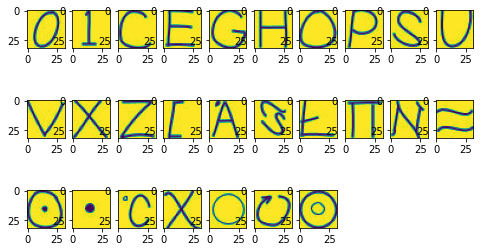

In [ ]:
# display all of the incorrect images
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 10
rows = 5
j = 1
for i in incorr:
    img = Image.open(str(i)+'.jpg').convert('L')
    fig.add_subplot(rows, columns, j)
    j +=1
    plt.imshow(img)
plt.show()

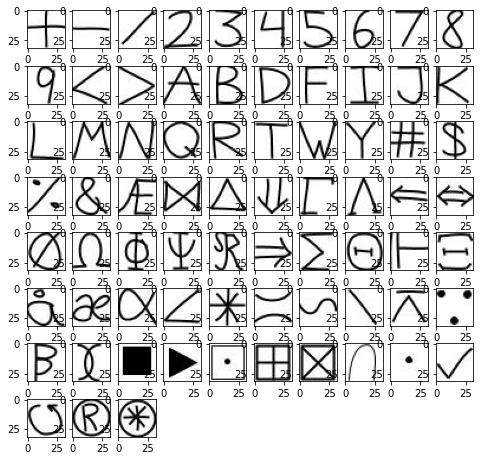

In [ ]:
# display all of the correct images
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 10
rows = 8
j = 1
for i in corr:
    img = Image.open(str(i)+'.jpg').convert('RGB')
    fig.add_subplot(rows, columns, j)
    j +=1
    plt.imshow(img)
plt.show()

In [ ]:
def maxN(elements, n):
    return sorted(elements, reverse=True)[:n]

In [ ]:
import heapq

In [ ]:
n_corr = 0
correct = []

for n in range(2,10):
  c = []
  n_corr=0
  for i in incorr:
    img = Image.open(str(i)+'.jpg').convert('L')
    arr=(model(t(img).unsqueeze(0).cuda())[0].cpu()).detach().numpy()#.max(1, keepdim=True)[1][0][0].item()
    idx = (-arr).argsort()[:n]
    for j in idx:
      if id_dict[j] == id_dict[i]:
        n_corr +=1
        # c.append(id_dict[j])
        correct.append(j)
  print(n_corr)

12
18
19
21
22
22
22
22


In [ ]:
correct = set(correct)

In [ ]:
correct

{4,
 17,
 19,
 21,
 22,
 29,
 30,
 33,
 36,
 38,
 40,
 41,
 46,
 53,
 60,
 70,
 73,
 75,
 88,
 91,
 93,
 96}

In [ ]:
incorr

[3,
 4,
 17,
 19,
 21,
 22,
 29,
 30,
 33,
 35,
 36,
 38,
 40,
 41,
 46,
 52,
 53,
 60,
 70,
 73,
 75,
 88,
 91,
 93,
 94,
 96,
 99]

In [ ]:
never=[94, 3, 35, 99, 52]
for n in never:
  print(id_dict[n])

\circ
0
U
\circledcirc
\Im


In [ ]:
def setdiff_sorted(array1,array2,assume_unique=False):
    ans = np.setdiff1d(array1,array2,assume_unique).tolist()
    if assume_unique:
        return sorted(ans)
    return ans

In [ ]:
np.setdiff1d(set(incorr),correct)

array([{3, 4, 17, 19, 21, 22, 29, 30, 33, 35, 36, 38, 40, 41, 46, 52, 53, 60, 70, 73, 75, 88, 91, 93, 94, 96, 99}],
      dtype=object)

In [ ]:
len(incorr)

27